# 参数更新

In [7]:
import numpy as np

### `SGD`

In [8]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

- 如果函数的形状非均向，比如呈延伸状，`SGD` 的搜索路径会非常低效
- 原因是，`SGD` 梯度的反向并没有指向最小值的方向。

### `Momentum`

In [9]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### `AdaGrad`
学习率衰减`(learning rate decay)`，随着学习的进行，学习率逐渐衰减。
- `AdaGrad`，学习率除以以前的所有梯度值的平方和，元素中变动较大的元素的学习率将减小

In [10]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### `Adam`
融合 `Momentum` 和 `AdaGrad` 两者

In [11]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (
            1.0 - self.beta1**self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

### 优化算法比较

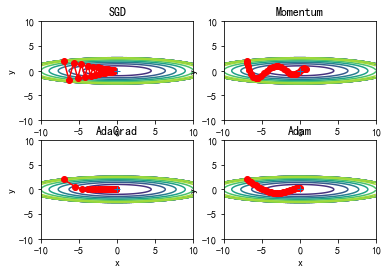

In [13]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0 * y


init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # for simple contour line
    mask = Z > 7
    Z[mask] = 0

    # plot
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.show();

# 激活函数与初始化
- 梯度消失\爆炸问题部分时因为选择的激活函数不当
- `ReLU` 函数的变体：
    - 𝐿𝑒𝑎𝑘𝑦𝑅𝑒𝐿𝑈𝛼(𝑧)=𝑚𝑎𝑥(𝛼𝑧,𝑧)，通常 𝛼=0.01,较小的斜率，保证用不为 0 
    - `randomized leaky ReLU (RReLU)`，训练时随机选择 𝛼 参数
    - `parametric leaky ReLU (PReLU)`， 𝛼 参数再训练时学习得到
    - `exponential linear unit (ELU)`:
    $$ELU_\alpha(z)=\begin{cases}\alpha(exp(z)-1)\quad if\ z<0\\z\qquad if\ z\geq 0
\end{cases}$$
- 一般的选择 `ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic`


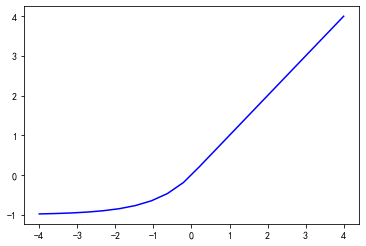

In [25]:
import numpy as np
import matplotlib.pyplot as plt


def elu(z):
    result = []
    for i in z:
        if i < 0:
            result.append(np.exp(i) - 1)
        if i >= 0:
            result.append(i)
    return (result)


x = np.linspace(-4, 4, 20)
plt.plot(x, elu(x), 'b-')

权值衰减`(weight decay)`，一种以减小权重参数的值为目的的进行学习的方法；通过减小权重参数的值来抑制过拟合的发生
- 一开始将初始值设为较小的值，当不能将权重初始值设置成相同的值；误差反向传播算法中，所有权重都会进行同样的更新，将无法正确进行学习

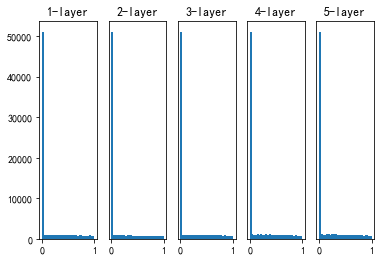

In [21]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)


input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    # 改变初始值进行实验！
#     w = np.random.randn(node_num, node_num) * 1
#     w = np.random.randn(node_num, node_num) * 0.01
#     w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    # 将激活函数的种类也改变，来进行实验！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

- 使用标准差为 1 的高斯分布作为权重初始值时，各层的激活值呈偏向 0 和 1 的分布；偏向 0 和 1 的数据分布会造成反向传播中梯度的值不断变小，最后消失；随着网络越深，梯度消失`(gradient vanishing)`的问题会更加严重
- 使用使用标准差为 0.01 的高斯分布作为权重初始值时，各层的激活值集中偏向 0.5；此时不会出现梯度消失的问题，但多个神经元输出几乎相同的值，神经网络会出现“表现力受限”的问题

   
- 直观来讲，每一层输出的差别变化幅度应当与输入变化幅度相当；梯度在反向传播经过每一层前后，变化幅度相同
- `Xavier` 初始化，使用 `sigmoid` 或 `tanh` 激活函数时的**最佳实践**
    - 以 0 为均值，$\sigma$ 为标准差的正态分布：$\sigma=\sqrt{\frac{2}{n_{inputs}+n_{outputs}}}$
    - $-r$到$+r$之间的均匀分布：$r=\sqrt{\frac{6}{n_{inputs}+n_{outputs}}}$
    - 简化为 $\sqrt{\frac{1}{n_{inputs}}}$
    - 此时各层激活值基本避免了上述两个问题
    
        - `He` 初始化，使用 `ReLU` 激活函数时的**最佳实践**，初始化为以 $\sqrt{\frac{1}{n}}$ 标准差的高斯分布；相比 `Xavier`，`ReLU` 负值区域的值为 0 ，为了使它更有广度，需要 2 倍的系数；

(1, 50000)


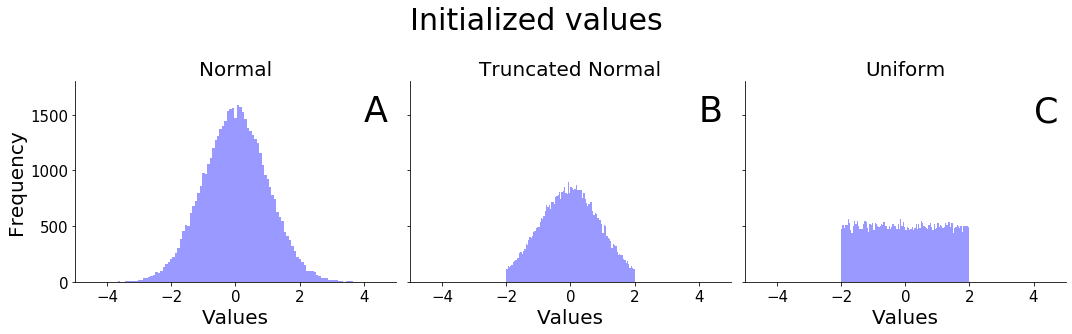

In [4]:
import matplotlib.pyplot as plt 
import tensorflow as tf
%matplotlib inline


# === Noramal and Truncated normal distributions ===
mean = 0
std = 1
x_normal = tf.random.normal((1,50000),mean,std)
x_truncated = tf.random.truncated_normal((1,50000),mean,std)

# === Uniform distribution
minval = -2 
maxval = 2
x_uniform = tf.random.uniform((1,50000),minval,maxval)


def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
#     ax.set_ylim([-1.1,1.1])
    ax.tick_params(axis='both', which='major', labelsize=15)
    
def get_axis_limits(ax, scale=.8):
    return ax.get_xlim()[1]*scale, ax.get_ylim()[1]*scale

f,axarr = plt.subplots(1,3,figsize=[15,4],sharey=True)
titles = ['Normal','Truncated Normal','Uniform']

print(x_normal.shape)
for i,x in enumerate([x_normal,x_truncated,x_uniform]):
    ax = axarr[i]
    ax.hist(x[0],bins=100,color='b',alpha=0.4)
    ax.set_title(titles[i],fontsize=20)
    ax.set_xlabel('Values',fontsize=20)
    ax.set_xlim([-5,5])
    ax.set_ylim([0,1800])
    
    simpleaxis(ax)
    
    
axarr[0].set_ylabel('Frequency',fontsize=20)
plt.suptitle('Initialized values',fontsize=30, y=1.15)


for ax,letter in zip(axarr,['A','B','C']):
    simpleaxis(ax)
    ax.annotate(letter, xy=get_axis_limits(ax),fontsize=35)

plt.tight_layout()

# plt.savefig('histograms.png', bbox_inches='tight', format='png', dpi=200, pad_inches=0,transparent=True)

plt.show()

# `Batch Normalization`
- 设定合适的初始值，则各层的激活值分布会有适当的广度，从而进行顺利学习
- “强制性”的调整激活值的分布，`Batch Normalization`
    - 在神经网络中插入对数据分布进行正规化的层，即 `Batch Normalization` 层，以进行学习时的 mini-batch 为单位，进行正规化
    
    
1. $\mu_B=\frac{1}{m}\sum_{i=1}^{m}x_i$
2. $\sigma_B^2=\frac{1}{m}\sum_{i=1}^{m}(x_i-\mu_B)^2$
3. $\hat{x_i}=\frac{x_i-\mu_B}{\sqrt{\sigma_B^2+\varepsilon}}$
    - $\hat{x_i}$ 以 0 为均值，方差为 1；$\varepsilon$ 微小值（如，$10^{-7}$），避免被 0 除，平滑项. 
4. $y_i=\gamma \hat{x_i}+\beta$
    - 对正规化后的数据进行缩放和平移变化，初始时$\gamma=1, \beta=0$ ，再通过学习调整到合适的值

Batch Norm 有以下优点：
- 可以使学习快速进行（可以增大学习率）
- 不那么依赖初始值，
- 抑制过拟合（降低 `Dropout` 等的必要性）

# 正则化
### 过拟合
- 只能拟合训练数据，不能很好的拟合不包含在训练数据中的数据
- 原因：模型拥有大量参数、表现力前；训练数据少


### 权值衰减
- 在学习的过程中对大的权值进行惩罚，来抑制过拟合；很多过拟合原本就是因为权重参数过大导致的
- 例如为损失函数加上权重的平方范式(L2范数)$\frac{1}{2}\lambda W^2$，误差反向传播时的梯度也要加上$\lambda W$
- 除了 $l2$ 范数，还有 $l1$ 和 $l\infty$范数都可以作为正则项

### `Dropout`
- 在学习的过程中随机删除神经元的方法，被删除的神经元不再进行信号的传递；测试时，会传递所有的神经元信号，但输出会乘上训练时的删除比例后再输出
- 训练时每次更新，都会随机删除神经元，相当于生成一个新的神经网络，`Dropout` 将集成学习的效果通过一个网络实现了

In [24]:
class Dropout:
    def __init__(self, dropout_ratio=0.2):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

# 超参数最优化选择
- 各层的神经元数量，batch 大小，学习率等